In [1]:
from power_calculator import calculate_power
import os
import pandas as pd
from scrape_cardlists import DATA_PATH
BASE_PWR_PATH = os.path.join(DATA_PATH, "decks", "baseline")
MANUAL_SAVE = os.path.join(DATA_PATH, "decks", "manual_rand")
GPT_SAVE = os.path.join(DATA_PATH, "completed")
DECKS = os.path.join(DATA_PATH, "decks")

In [21]:
import os
import ast
import pandas as pd
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def compile_power(directory):
    data = []  # To hold dictionaries from files
    for root, dirs, files in os.walk(directory):
        folder_name = os.path.basename(root)  # Get the current folder name
        for file in files:
            if file.endswith(".txt"):
                file_path = os.path.join(root, file)
                #print(file_path)
                with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
                    lines = f.readlines()
                    if lines:
                        try:
                            # Convert the last line to a dictionary
                            last_line_dict = ast.literal_eval(lines[-1].strip())
                            # Ensure it's actually a dictionary
                            if isinstance(last_line_dict, dict):
                                last_line_dict['folder'] = folder_name  # Add folder name to the dictionary
                                data.append(last_line_dict)
                        except (ValueError, SyntaxError):
                            print(f"Error processing file: {file_path}")
                            continue
    return pd.DataFrame(data)

# Replace 'path_to_your_directory' with the actual path to your directory
directory_path = 'path_to_your_directory'

df = compile_power(DECKS)
for col in df:
    try:
        df[col] = pd.to_numeric(df[col])
    except:
        pass

df.head()

Error processing file: c:\Users\theod\edh-llm\data\decks\gpt\RakkaMar.txt


,overall,cmc,ramp,draw,interaction,folder
0,4,2.772727,32,35,0,baseline
1,1,3.424242,1,0,9,baseline
2,1,3.953846,1,2,1,baseline
3,4,3.769231,2,26,7,baseline
4,4,3.661538,4,29,4,baseline


In [23]:
df.groupby('folder').count()

,overall,cmc,ramp,draw,interaction
folder,,,,,
baseline,189,189,189,189,189
edh,189,189,189,189,189
gpt,188,188,188,188,188
manual_rand,189,189,189,189,189


In [24]:
df.groupby('folder').median()

,overall,cmc,ramp,draw,interaction
folder,,,,,
baseline,2.0,3.393939,1.0,5.0,4.0
edh,7.0,2.555556,11.0,11.0,8.0
gpt,5.0,3.307692,6.0,10.0,9.0
manual_rand,4.0,3.294118,4.0,10.0,8.0


In [25]:
df.groupby('folder').mean()

,overall,cmc,ramp,draw,interaction
folder,,,,,
baseline,2.566138,3.175908,3.867725,9.735450,6.571429
edh,6.777778,2.565718,11.925926,11.507937,8.105820
gpt,5.148936,3.145667,6.835106,11.452128,9.707447
manual_rand,4.359788,3.239884,5.158730,11.227513,8.650794


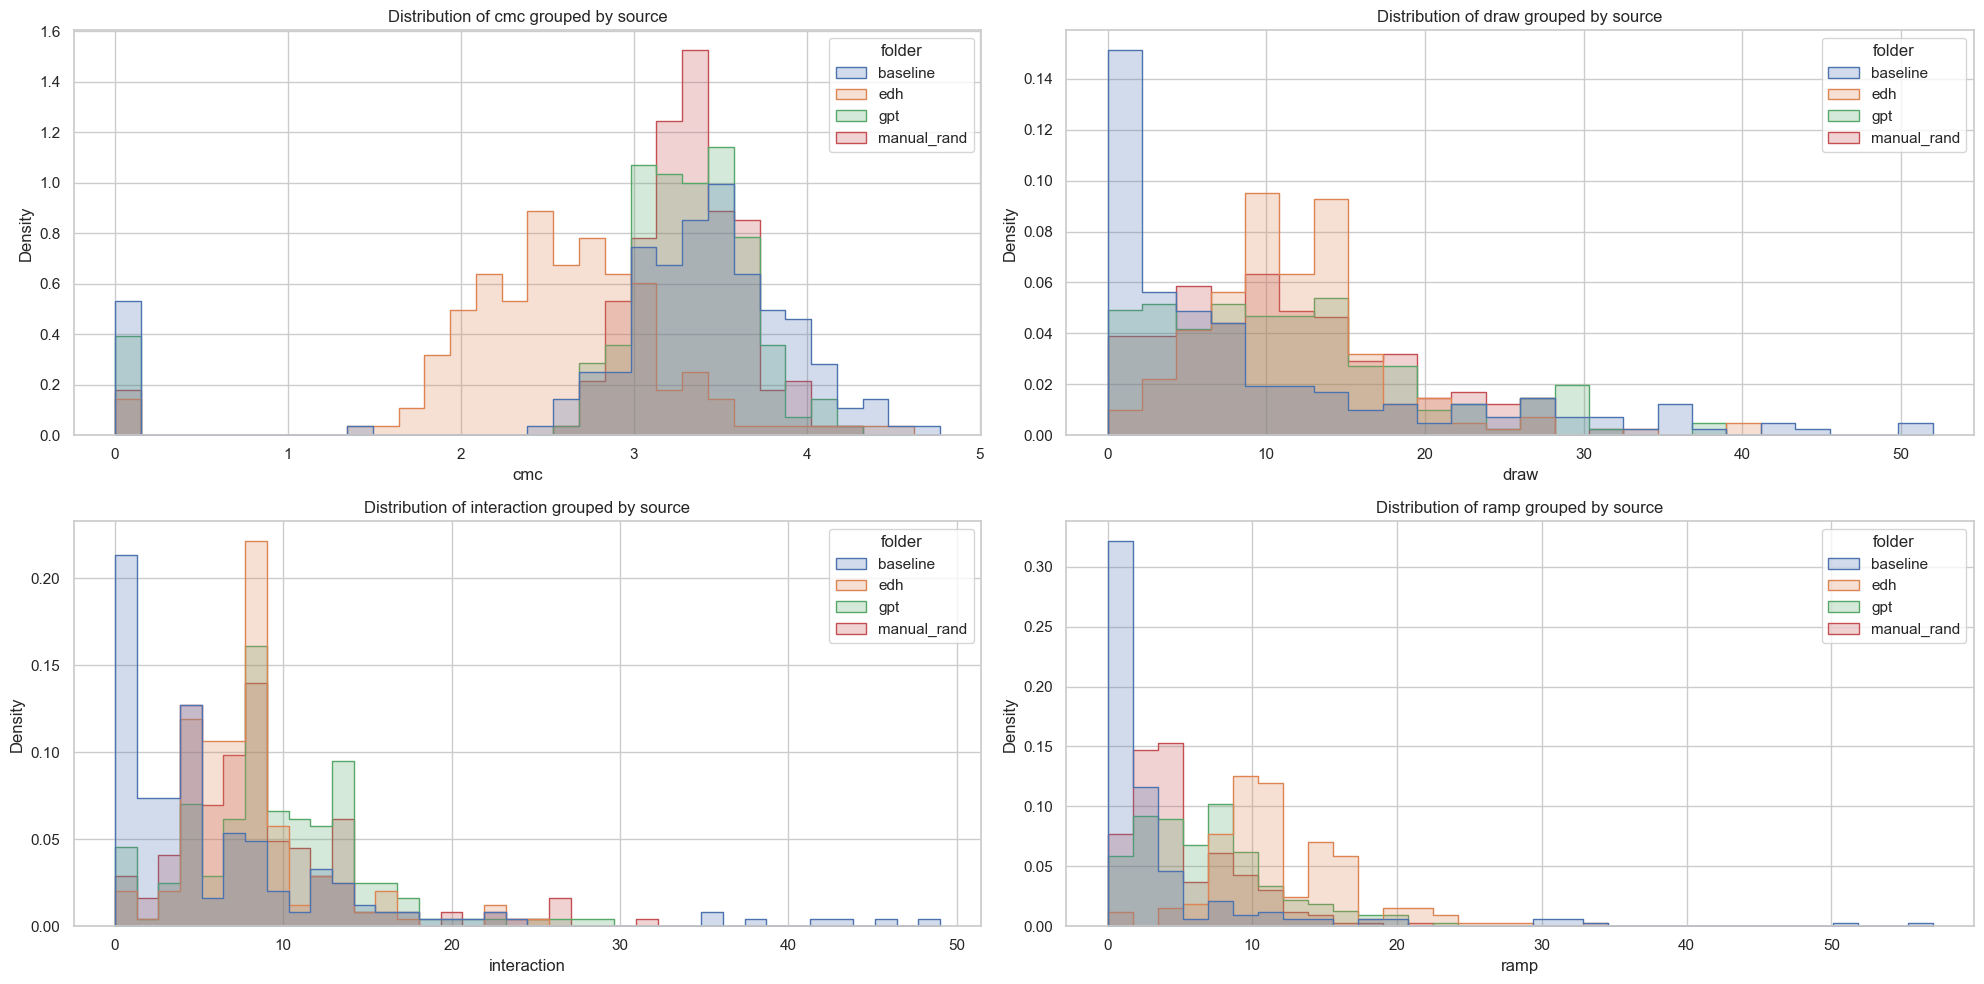

In [26]:
sns.set(style="whitegrid")
plt.figure(figsize=(20, 10))

# Create a column list excluding 'folder'
columns = df.columns.difference(['folder', 'overall'])

# Plotting
for i, column in enumerate(columns, 1):
    plt.subplot(2, 2, i)
    sns.histplot(data=df, x=column, hue="folder", element="step", stat="density", common_norm=False)
    plt.title(f'Distribution of {column} grouped by source')

plt.tight_layout()
plt.show()

In [46]:
df[df['cmc'] == 0]

,overall,cmc,ramp,draw,interaction,folder
149,1,0.0,0,0,0,gpt


In [91]:
from scipy.stats import f_oneway

for col in df.columns.difference(['folder']):
    # Similar setup as Kruskal-Wallis but for ANOVA
    data = [df[df['folder'] == folder][col] for folder in df['folder'].unique()]

    # Perform ANOVA
    stat, p = f_oneway(*data)

    print(col + ' Statistics= %.3f, p= %.3f' % (stat, p))
    if p > 0.05:
        print('Same means across all groups (fail to reject H0)')
    else:
        print('Different means across some groups (reject H0)')

cmc Statistics= 52.901, p= 0.000
Different means across some groups (reject H0)
draw Statistics= 3.417, p= 0.017
Different means across some groups (reject H0)
interaction Statistics= 2.358, p= 0.071
Same means across all groups (fail to reject H0)
overall Statistics= 162.982, p= 0.000
Different means across some groups (reject H0)
ramp Statistics= 44.858, p= 0.000
Different means across some groups (reject H0)


In [92]:
df.columns.difference(['baseline'])

Index(['cmc', 'draw', 'folder', 'interaction', 'overall', 'ramp'], dtype='object')

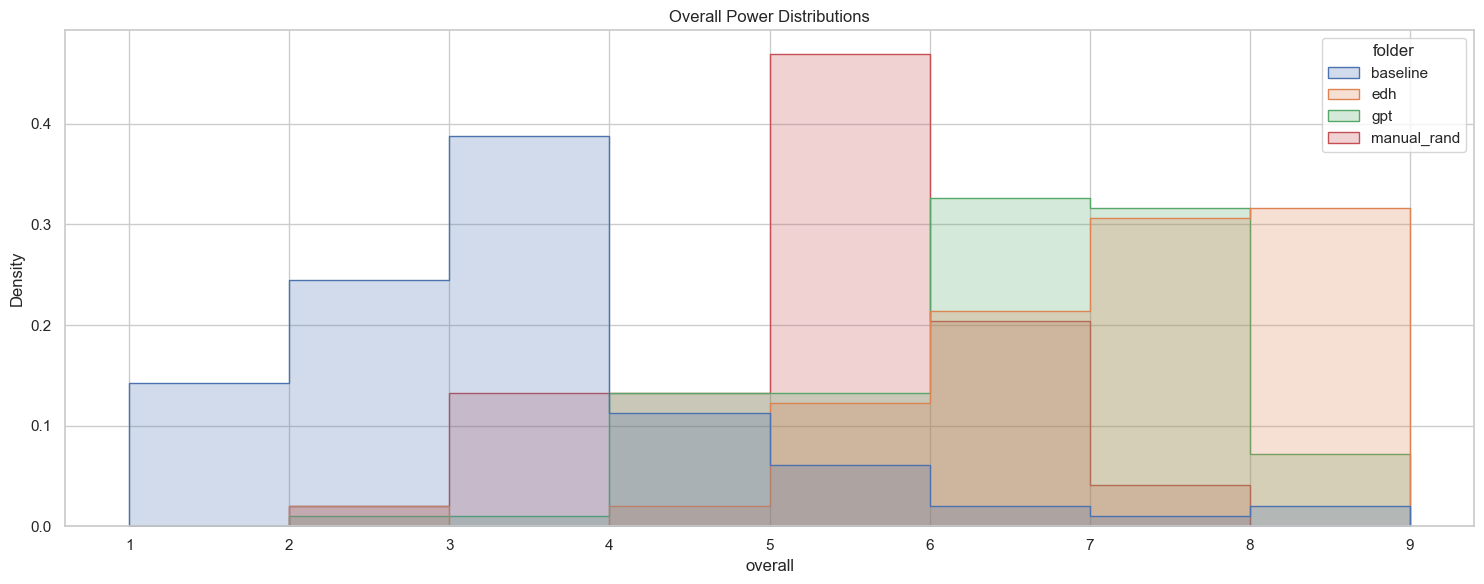

In [94]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and 'overall' is the column of interest
sns.set(style="whitegrid")

# Calculate appropriate bin edges to cover the full range of data without gaps
bin_edges = range(int(df['overall'].min()), int(df['overall'].max()) + 2)  # +2 to ensure the last data point is included

plt.figure(figsize=(15, 6))  # Adjust size as needed
sns.histplot(data=df, x='overall', hue='folder', binwidth=1, bins=bin_edges, stat="density", element="step", common_norm=False)
plt.title('Overall Power Distributions')
plt.tight_layout()
plt.show()